In [3]:
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Fri Aug 31 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-33-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os


PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
print(PROJ_ROOT)
print(DATA_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
from data.preprocess import read_raw_data, preprocess_data

/home/miroslav/Source/thesis_project
/home/miroslav/Source/thesis_project/data


In [5]:
import mne

Creating RawArray with float64 data, n_channels=19, n_times=19105
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


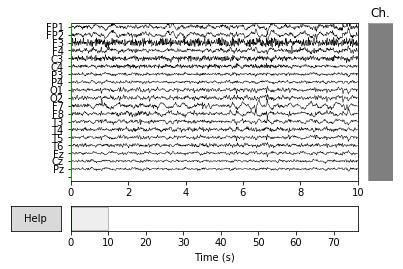

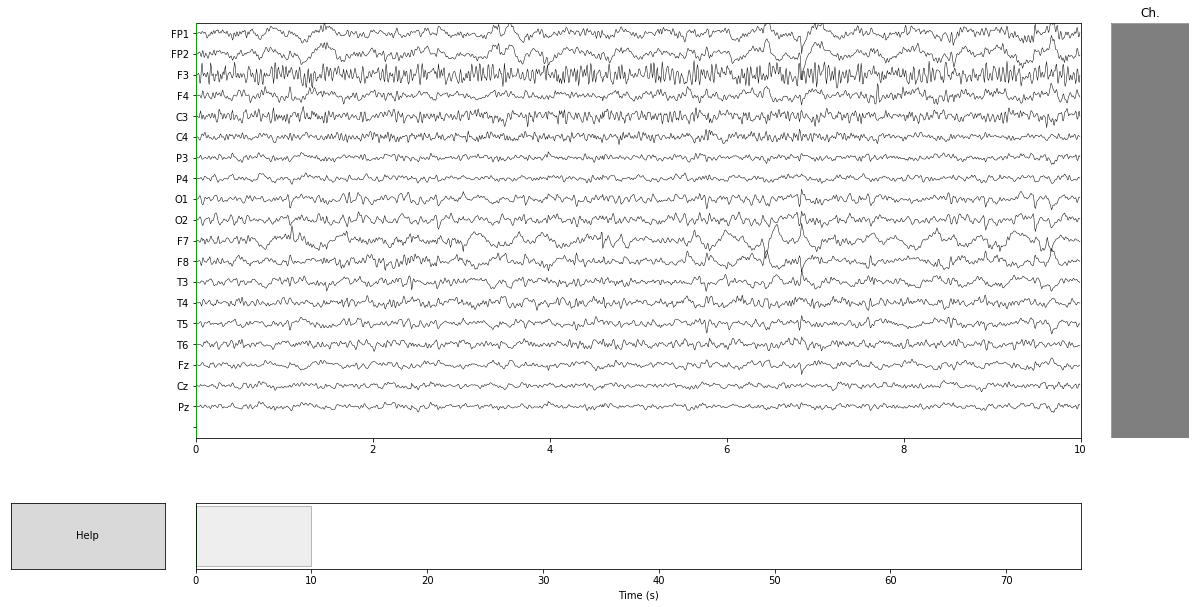

In [11]:
names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
         'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

raw_root = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
filename = '1a.tdt'
df = pd.read_table(os.path.join(raw_root, filename), sep='\t', names=names, skiprows=[0])

info = mne.create_info(ch_names=names, sfreq=250, ch_types='eeg')
data = mne.io.RawArray(np.transpose(df.values), info)

data.set_eeg_reference('average', projection=True)  # set EEG average reference
data.apply_proj()
fig = data.plot(block=True, lowpass=40, scalings='auto')
fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()